In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [2]:
!kaggle datasets download -d splcher/animefacedataset

100% 394M/395M [00:13<00:00, 40.3MB/s]
100% 395M/395M [00:13<00:00, 31.6MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('/content/animefacedataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/animefacedataset/')

In [4]:
data_dir = '/content/animefacedataset'

In [5]:
print(os.listdir(data_dir+'/images')[:5])

['8776_2004.jpg', '5318_2003.jpg', '31825_2010.jpg', '14436_2006.jpg', '55479_2016.jpg']


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
img_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5) #Stats for normaliztion image

In [8]:
# Preprocessing on data
train_tfms = T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [9]:
# Applying transformation on Dataset
train_ds = ImageFolder(data_dir, train_tfms)

In [10]:
# Loading dataset
"""
If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory.
This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.
"""
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True, pin_memory=True)

In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def denorm(img_tensor):
  return img_tensor * stats[1][0] + stats[0][0]

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

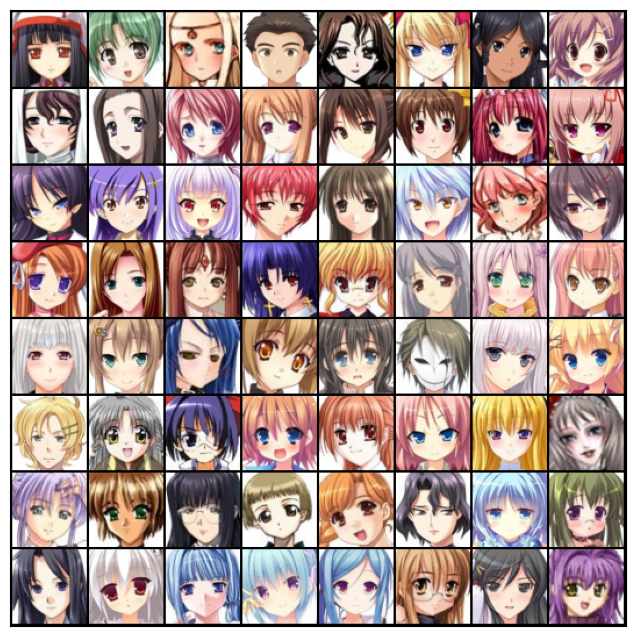

In [14]:
show_batch(train_dl)

In [49]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [50]:
device = get_default_device()
device

device(type='cuda')

In [51]:
train_dl = DeviceDataLoader(train_dl, device)

In [52]:
import torch.nn as nn

In [53]:
# discriminator thinks images are fake So will define descriminator first
discriminator = nn.Sequential(
    nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64,128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128,256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512,1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [54]:
discriminator = to_device(discriminator, device)

In [55]:
latent_size = 128 # U can choose any latent value More the size more the noise and more better generation

In [56]:
# Generater is also Deconvolution

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    #out: 512 x 4 x 4
    nn.ConvTranspose2d(512,256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    #out: 256 x 8 x 8
    nn.ConvTranspose2d(256,128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    #out: 128 x 16 x 16
    nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    #out: 64 x 32 x 32
    nn.ConvTranspose2d(64,3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

    #out: 3 x 64 x 64
)


torch.Size([128, 3, 64, 64])


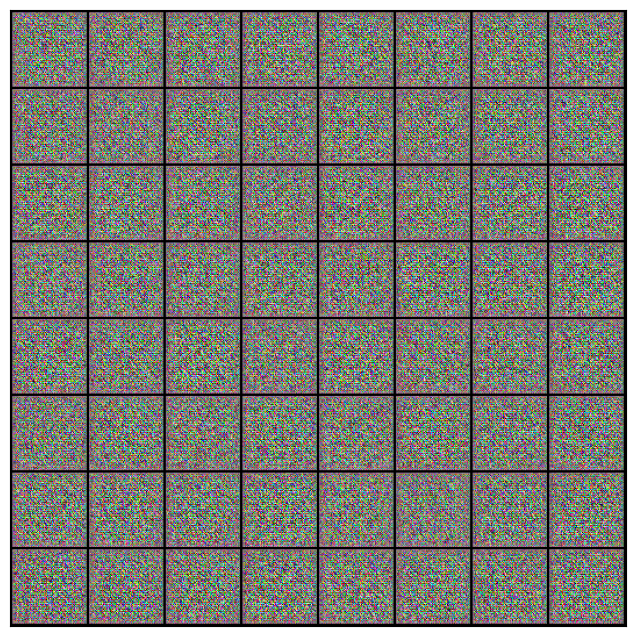

In [57]:
xb = torch.randn(batch_size, latent_size,1,1)
fake_image = (generator(xb))
print(fake_image.shape)
show_images(fake_image)

In [58]:
generator = to_device(generator, device)

In [59]:
import torch.nn.functional as F

In [60]:
def train_descriminator(real_images, opti_d):
  opti_d.zero_grad()

  #Pass real image through descrimiator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0),1,device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  #passing fake images through descriminator
  fake_targets = torch.zeros(fake_images.size(0),1,device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()


  #Update discriminator

  loss = real_loss+fake_loss
  loss.backward()
  opti_d.step()
  return loss.item(), real_score, fake_score


In [61]:
def train_genrator(opti_g):
  # Clear Genrator gradient
  opti_g.zero_grad()

  latent = torch.randn(batch_size, latent_size,1,1, device=device)
  fake_images = generator(latent)

  #Fooling descriminator

  pred = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(pred, targets)

  loss.backward()
  opti_g.step()

  return loss.item()

In [62]:
from torchvision.utils import save_image

In [63]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [64]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [65]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


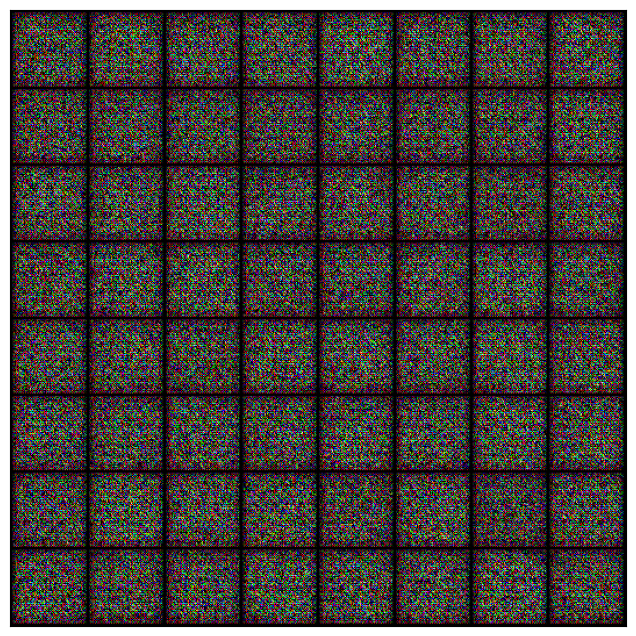

In [66]:
save_samples(0, fixed_latent)

The term Beta (𝛽) controls the moving average. The value of Beta is [0,1), a common value is 𝛽 = 0.9, meaning we are averaging over the last 10 iterations' gradients and the older gradients are discarded or forgotten. So, a large value of beta (say 𝛽 = 0.98) means that we are averaging over more gradients

In [67]:
"""tqdm can help you create progress bars for data processing,
 training machine learning models,
 multi-loop Python function, and downloading data from the internet"""
from tqdm.notebook import tqdm

In [71]:
def fit(epochs, lr, start_idx=1):

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opti_d = torch.optim.Adam(discriminator.parameters(), lr=lr,betas=(0.5,0.999))
  opti_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      loss_d, real_score, fake_score = train_descriminator(real_images, opti_d)
      loss_g = train_genrator(opti_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    save_samples(epoch+start_idx, fixed_latent, show=False)
  return losses_g, losses_d, real_scores, fake_scores

In [72]:
lr = 0.0002
epochs=25

In [73]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 5.9911, loss_d: 0.3945, real_score: 0.8464, fake_score: 0.1701
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 6.5679, loss_d: 0.2782, real_score: 0.9486, fake_score: 0.1871
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.6597, loss_d: 0.1917, real_score: 0.8950, fake_score: 0.0558
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.6038, loss_d: 0.0549, real_score: 0.9773, fake_score: 0.0297
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 6.5276, loss_d: 0.0372, real_score: 0.9697, fake_score: 0.0017
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 9.8844, loss_d: 0.1077, real_score: 0.9166, fake_score: 0.0008
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 6.1507, loss_d: 0.1144, real_score: 0.9304, fake_score: 0.0256
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 5.1498, loss_d: 0.1434, real_score: 0.9259, fake_score: 0.0329
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 7.4205, loss_d: 0.1248, real_score: 0.9707, fake_score: 0.0745
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 7.0011, loss_d: 0.1444, real_score: 0.9574, fake_score: 0.0654
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 5.5250, loss_d: 0.0819, real_score: 0.9530, fake_score: 0.0261
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 5.9169, loss_d: 0.1321, real_score: 0.9012, fake_score: 0.0038
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.7057, loss_d: 0.0075, real_score: 0.9984, fake_score: 0.0059
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 8.6426, loss_d: 0.2356, real_score: 0.8496, fake_score: 0.0010
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 7.2952, loss_d: 0.1009, real_score: 0.9423, fake_score: 0.0130
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.9350, loss_d: 0.3776, real_score: 0.8681, fake_score: 0.0078
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 6.6215, loss_d: 0.0656, real_score: 0.9806, fake_score: 0.0426
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 11.2463, loss_d: 0.4451, real_score: 0.9999, fake_score: 0.2289
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.3670, loss_d: 0.0090, real_score: 0.9976, fake_score: 0.0065
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 5.0705, loss_d: 0.0598, real_score: 0.9611, fake_score: 0.0132
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 8.4084, loss_d: 0.0470, real_score: 0.9814, fake_score: 0.0267
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 10.3683, loss_d: 0.0279, real_score: 0.9755, fake_score: 0.0002
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 6.8063, loss_d: 0.0523, real_score: 0.9881, fake_score: 0.0380
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 7.2941, loss_d: 0.0241, real_score: 0.9926, fake_score: 0.0161
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 7.4344, loss_d: 0.0463, real_score: 0.9809, fake_score: 0.0243
Saving generated-images-0025.png


In [74]:
losses_g, losses_d, real_scores, fake_scores = history

In [75]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [76]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

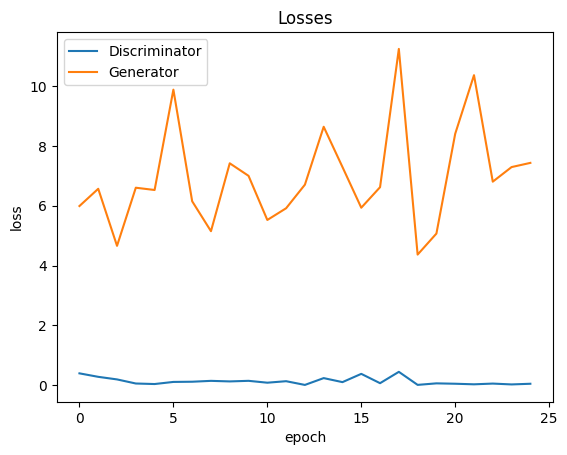

In [77]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

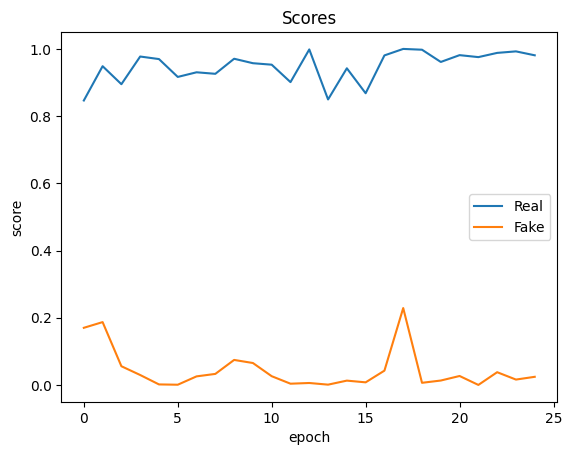

In [78]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
#We want genrator perform better so generator loss should be small